In [289]:
import numpy as np                                     
import matplotlib.pyplot as plt                      
import seaborn as sns                                
from iminuit import Minuit                      
import sys             
from sympy import *                           
from scipy import stats
from scipy.special import binom as binomcoef
from scipy.special import expit, gamma
from scipy.integrate import trapz, simpson
import scipy.interpolate as scint
import pandas as pd
import os
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import GradientBoostingClassifier as Gra_classifier
from sklearn.ensemble import AdaBoostClassifier as Ada_classifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import itertools
from importlib import reload

plt.style.use("../KD_style.mplstyle")

In [290]:
def num_int2(func, xmin, xmax, points = 1000000, **kwargs):
    x = np.linspace(xmin, xmax, points)
    y = func(x, **kwargs)
    y_ave = y[1:] + (y[1:] - y[:-1])/2
    width = (xmax-xmin)/(points-1)
    area = np.sum(y_ave)*width
    return area

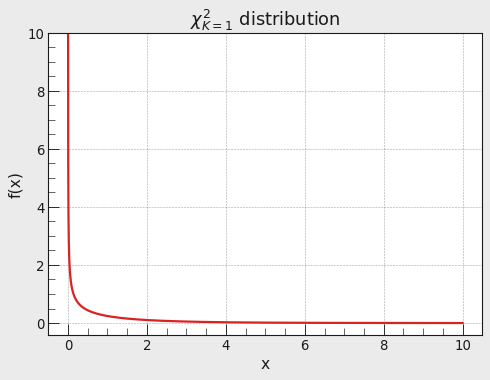

In [291]:
xlin = np.linspace(0, 10, 10000)
plt.plot(xlin, stats.chi2.pdf(xlin, 1))
plt.ylim(-0.4, 10)

plt.ylabel("f(x)")
plt.xlabel("x")
plt.title(r"$ \chi^{2}_{K=1}$ distribution")
plt.savefig("chi2.png", facecolor = "white")

## Problem 2

In [292]:
# The -2LLH diference with the function of 4 parameters will follow a chi2 distribution with 4 DoF
stepsize = 0.00001
for x in np.arange(5.7, 5.8, stepsize):
    if stats.chi2.cdf(x, 4) >= 0.779:
        print(x)
        break
# the deference in 2LLH for the confidence interval of 77.9% is 5.71

5.720709999999216


## Problem 3

In [293]:
shark_data = pd.read_csv("./WhiteSharkLength.txt", skiprows=1)
display(shark_data)

,Length
0,400.0
1,450.0
2,580.0
3,337.0
4,602.0
...,...
164,533.0
165,500.0
166,500.0
167,450.0


0.9999885593265875


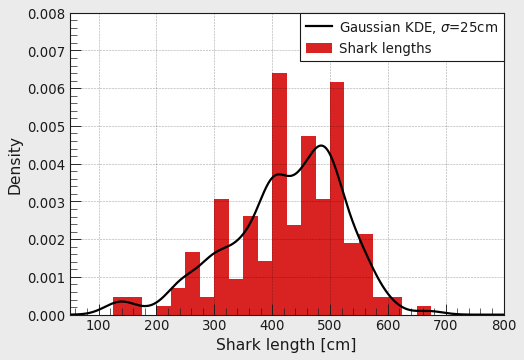

In [294]:
fig, ax = plt.subplots()
ax.hist(shark_data, bins = 24, range =[100, 700], density = True, label = "Shark lengths")

length_50_800_01 = np.arange(50, 800, 0.1)
kde = np.zeros_like(length_50_800_01)
sigma = 25
for length in shark_data["Length"]:
    kde_con = stats.norm.pdf(length_50_800_01, length, sigma)
    kde += kde_con
    
kde /= len(shark_data["Length"])
ax.plot(length_50_800_01, kde, color = "k", label = f"Gaussian KDE, $ \sigma$=25cm")
ax.set(ylabel = "Density", xlabel = "Shark length [cm]")
ylim = ax.set_ylim()
ax.set_ylim(ylim[0], round(ylim[1]*1.2,3))
ax.set_xlim(50, 800)
plt.legend()
# plt.show()
plt.savefig("./kde.png", facecolor = "white")
print(simpson(kde, length_50_800_01))

[-13.37260019 -13.36005975 -13.34753471 ... -22.72538504 -22.74614505
 -22.76692105]


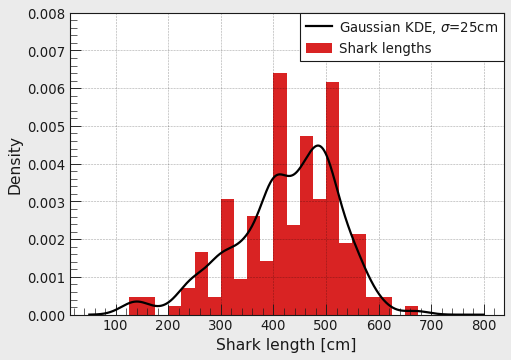

In [295]:
# scipy_kde = stats.gaussian_kde(shark_data["Length"].values)
# scipy_kde.set_bandwidth(sigma)
sk_kde = KernelDensity(kernel = "gaussian", bandwidth=sigma)
sk_kde.fit(shark_data["Length"].to_numpy().reshape(-1,1))
# sk_kde.sample
# sk_kde.
fig, ax = plt.subplots()
ax.hist(shark_data, bins = 24, range =[100, 700], density = True, label = "Shark lengths")
print(sk_kde.score_samples(length_50_800_01.reshape(-1,1)))

ax.plot(length_50_800_01, np.exp(sk_kde.score_samples(length_50_800_01.reshape(-1,1))), color = "k", label = f"Gaussian KDE, $ \sigma$=25cm")
ax.set(ylabel = "Density", xlabel = "Shark length [cm]")
ylim = ax.set_ylim()
ax.set_ylim(ylim[0], round(ylim[1]*1.2,3))
# ax.set_xlim(50, )
plt.legend()


In [302]:
print(length_50_800_01[6031])
kde_cdf = np.cumsum(kde)/10
print(1-kde_cdf[6031]) # = 0.005
print(kde_cdf[-1])
print(kde.shape, length_50_800_01.shape)
print(simpson(kde, length_50_800_01))
print(kde[6030])
print(simpson(kde[6031:], length_50_800_01[6031:]))

653.1000000000085
0.004693426366668696
0.9999886370309058
(7500,) (7500,)
0.9999885593265875
0.00010015839484600818
0.004687070200935831


0.0014563856832592633
0.47595727772614405
1.0


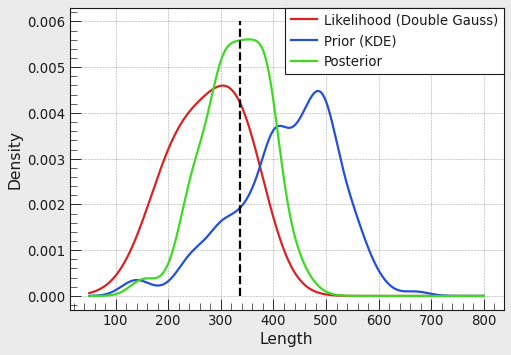

In [312]:
# P(L|W = 763, M) = P(W= 763|L,M)P(L)P(M)/P(W = 763)
# P(L|W = 763, F) = P(W= 763|L,F)P(L)P(F)/P(W = 763)
# P(L, W = 763) = P(L|W = 763, M) + P(L|W = 763, F)
def male_length(W, L):  
    return stats.norm.pdf(L, 0.293*W, 62)
 
def female_length(W, L):
    return stats.norm.pdf(L, 0.434*W, 55)

weight = 763
def llh(lengths, male):
    llh_values = np.zeros_like(lengths)
    weight_array = np.linspace(weight-0.01, weight+0.01, 1000)
    if male:
        for idx, length in enumerate(lengths):
            
            p_w = simpson(male_length(weight_array, length), weight_array)*50
            llh_values[idx] = p_w
    else:
        for idx, length in enumerate(lengths):
            p_w = num_int2(female_length, weight-0.1, weight+0.1, points = 100, L = length, W = weight)
            llh_values[idx] = p_w
    return llh_values
# weight_range = np.arange(100, 2000, 1, dtype=np.float64)
lengths = np.arange(337, 3000, 1)
# posteriors = np.zeros_like(weight_range)
# likelihoods = np.zeros_like(weight_range)

# for idx, weight in enumerate(weight_range):
#     posteriors[idx] = np.sum(1/2*(male_length(weight, xline[2871:]) + female_length(weight, xline[2871:]))*kde[2871:])/10
#     posteriors[idx] /= np.sum(1/2*(male_length(weight, xline) + female_length(weight, xline))*kde)/10
#     likelihoods[idx] = np.sum(1/2*(male_length(weight, xline[2871:]) + female_length(weight, xline[2871:]))*kde[2871:])/10
L_over_337 = length_50_800_01[2871:]
likelihood = 1/2*(male_length(weight, L_over_337) + female_length(weight, L_over_337))
prior = kde[2871:]
posterior = likelihood * prior
marginal = simpson(1/2*(male_length(weight, length_50_800_01) + female_length(weight, length_50_800_01))*kde, length_50_800_01)
print(marginal)
posterior /= marginal
print(simpson(posterior, length_50_800_01[2871:]))
# plt.plot(length_50_800_01, 1/2*(male_length(weight, length_50_800_01)))
# plt.plot(length_50_800_01, 1/2*llh(length_50_800_01, True))
plt.show()
plt.plot(length_50_800_01, 1/2*(male_length(weight, length_50_800_01) + female_length(weight, length_50_800_01)), label = "Likelihood (Double Gauss)")
plt.plot(length_50_800_01, kde, label = "Prior (KDE)")
plt.plot(length_50_800_01, 1/2*(male_length(weight, length_50_800_01) + female_length(weight, length_50_800_01))*kde/simpson(1/2*(male_length(weight, length_50_800_01) + female_length(weight, length_50_800_01))*kde, length_50_800_01), label = "Posterior")
plt.vlines(337, 0, 0.006, color = "k", zorder = 10, linestyles= "--")
plt.xlabel("Length")
plt.ylabel("Density")
plt.legend()
plt.savefig("posterior.pdf", facecolor = "white")
print(simpson(1/2*(male_length(weight, length_50_800_01) + female_length(weight, length_50_800_01))*kde/simpson(1/2*(male_length(weight, length_50_800_01) + female_length(weight, length_50_800_01))*kde, length_50_800_01), length_50_800_01))
# print(simpson(1/2*(male_length(weight, length_50_800_01) + female_length(weight, length_50_800_01)), length_50_800_01)*simpson(kde, length_50_800_01)/simpson(1/2*(male_length(weight, length_50_800_01) + female_length(weight, length_50_800_01))*kde, length_50_800_01))

[337.1 337.2 337.3 ... 799.7 799.8 799.9]
0.4465764629672192


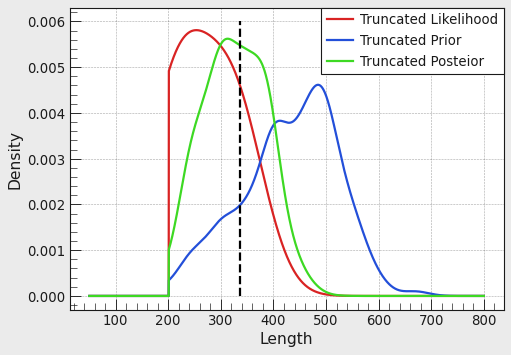

In [313]:
# 3c
# def male_length_trun(W, L):
#     L_array = np.array([stats.norm.pdf(length, 0.293*W, 62) if length>201 else 0 for length in L])
#     L_array /= simpson(L_array, L)
#     return L_array
 
# def female_length_trun(W, L):
#     L_array = np.array([stats.norm.pdf(length, 0.434*W, 55) if length>201 else 0 for length in L])
#     L_array /= simpson(L_array, L)
#     return L_array

def truncate_array(x, y, cutoff = 201):
    L_array = np.array([y_value if x_value>cutoff else 0 for x_value, y_value in zip(x, y)])
    L_array /= simpson(L_array, x)
    return L_array

trun_full_prior = truncate_array(length_50_800_01, kde)
# plt.plot(length_50_800_01, trun_kde)
# plt.plot(length_50_800_01, kde)
trun_full_likelihood = 1/2*(truncate_array(length_50_800_01, male_length(weight, length_50_800_01)) + truncate_array(length_50_800_01, female_length(weight, length_50_800_01)))
trun_full_marginal = simpson(trun_full_likelihood*trun_full_prior, length_50_800_01)
trun_full_posterior = trun_full_likelihood*trun_full_prior/trun_full_marginal
plt.plot(length_50_800_01, trun_full_likelihood, label = "Truncated Likelihood")
plt.plot(length_50_800_01, trun_full_prior, label = "Truncated Prior")
plt.plot(length_50_800_01, trun_full_posterior, label = "Truncated Posteior")
plt.vlines(337, 0, 0.006, color = "k", zorder = 10, linestyles= "--")
plt.legend()
plt.xlabel("Length")
plt.ylabel("Density")
plt.savefig("trun_posterior.pdf", facecolor = "white")
print(length_50_800_01[2871:])
print(simpson(trun_full_posterior[2871:], length_50_800_01[2871:]))
# plt.plot(length_50_800_01, 1/2*(male_length(weight, length_50_800_01) + female_length(weight, length_50_800_01)))
# plt.plot(length_50_800_01, kde)
# plt.plot(length_50_800_01, 1/2*(male_length(weight, length_50_800_01) + female_length(weight, length_50_800_01))*kde/simpson(1/2*(male_length(weight, length_50_800_01) + female_length(weight, length_50_800_01))*kde, length_50_800_01))

In [315]:
test = pd.read_csv("./Set3_Prob4_TestData.csv", index_col=0)
train = pd.read_csv("./Set3_Prob4_TrainData.csv", index_col=0)
blind = pd.read_csv("./Set3_Prob4_BlindData.csv", index_col=0)
display(test)
display(train)
display(blind)

,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
ID,,,,,,,,,,,,,,,,
3000,0.0,0.0,7.0,578.200000,0.000000,0.033333,58.48800,0.0,5,2,5,3,6,0,1,1
3001,0.0,0.0,4.0,2528.000000,0.000000,0.066667,0.00000,0.0,3,2,2,9,1,0,1,0
3002,0.0,0.0,30.0,1038.791667,0.006667,0.026667,0.00000,0.0,11,3,2,1,2,0,0,0
3003,0.0,0.0,21.0,2008.833333,0.000000,0.022857,0.00000,0.6,5,4,1,1,2,0,0,0
3004,0.0,0.0,23.0,226.256410,0.008696,0.010435,0.00000,0.6,5,4,2,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,15.0,440.000000,0.000000,0.033333,0.00000,0.8,5,4,1,4,2,0,0,0
5996,0.0,0.0,9.0,1362.000000,0.000000,0.008333,0.00000,0.0,3,2,2,7,6,0,0,0
5997,0.0,0.0,20.0,504.233333,0.010000,0.021667,0.00000,0.0,3,3,2,1,1,0,0,0


,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
ID,,,,,,,,,,,,,,,,
0,0.0,0.000000,18.0,941.916667,0.000000,0.001429,0.000000,0.0,11,2,2,1,2,1,0,0
1,0.0,0.000000,53.0,1170.733333,0.007273,0.025455,31.903201,0.0,8,2,4,2,3,0,0,1
2,0.0,0.000000,17.0,750.166667,0.000000,0.005556,0.000000,0.0,3,3,2,4,2,0,0,0
3,0.0,0.000000,9.0,237.333333,0.000000,0.031667,0.000000,0.0,5,1,1,1,3,0,0,0
4,1.0,20.000000,36.0,1279.166667,0.000000,0.010811,0.000000,0.0,3,2,2,1,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.0,0.000000,10.0,558.000000,0.011765,0.023529,0.000000,0.0,11,2,5,1,11,0,0,0
2996,1.0,25.166667,21.0,446.000000,0.019048,0.031746,32.388528,0.0,11,2,2,1,1,0,0,0
2997,0.0,0.000000,54.0,801.509524,0.007547,0.013275,0.000000,0.2,5,1,1,1,3,0,0,0


,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
ID,,,,,,,,,,,,,,,
6000,0.0,0.00,7.0,168.750000,0.000000,0.009524,0.000000,0.0,11,3,2,1,2,0,0
6001,0.0,0.00,3.0,54.400000,0.066667,0.133333,0.000000,0.0,7,3,2,4,3,0,1
6002,2.0,390.00,32.0,904.566667,0.009009,0.025405,0.000000,0.0,12,1,2,1,2,0,1
6003,0.0,0.00,7.0,277.166667,0.028571,0.050000,0.000000,0.0,11,3,2,4,13,0,0
6004,0.0,0.00,6.0,102.200000,0.000000,0.000000,40.278152,0.0,10,2,2,2,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,3.0,419.00,22.0,1005.806061,0.000000,0.007407,0.000000,0.0,3,2,2,2,2,1,1
8996,1.0,15.75,21.0,1615.660256,0.000000,0.009938,0.000000,0.0,12,2,2,8,2,1,1
8997,0.0,0.00,36.0,2362.500000,0.000000,0.016190,0.000000,0.6,5,2,5,1,4,0,0


In [ ]:
# g = sns.PairGrid(data=train, hue="Revenue")
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()

14


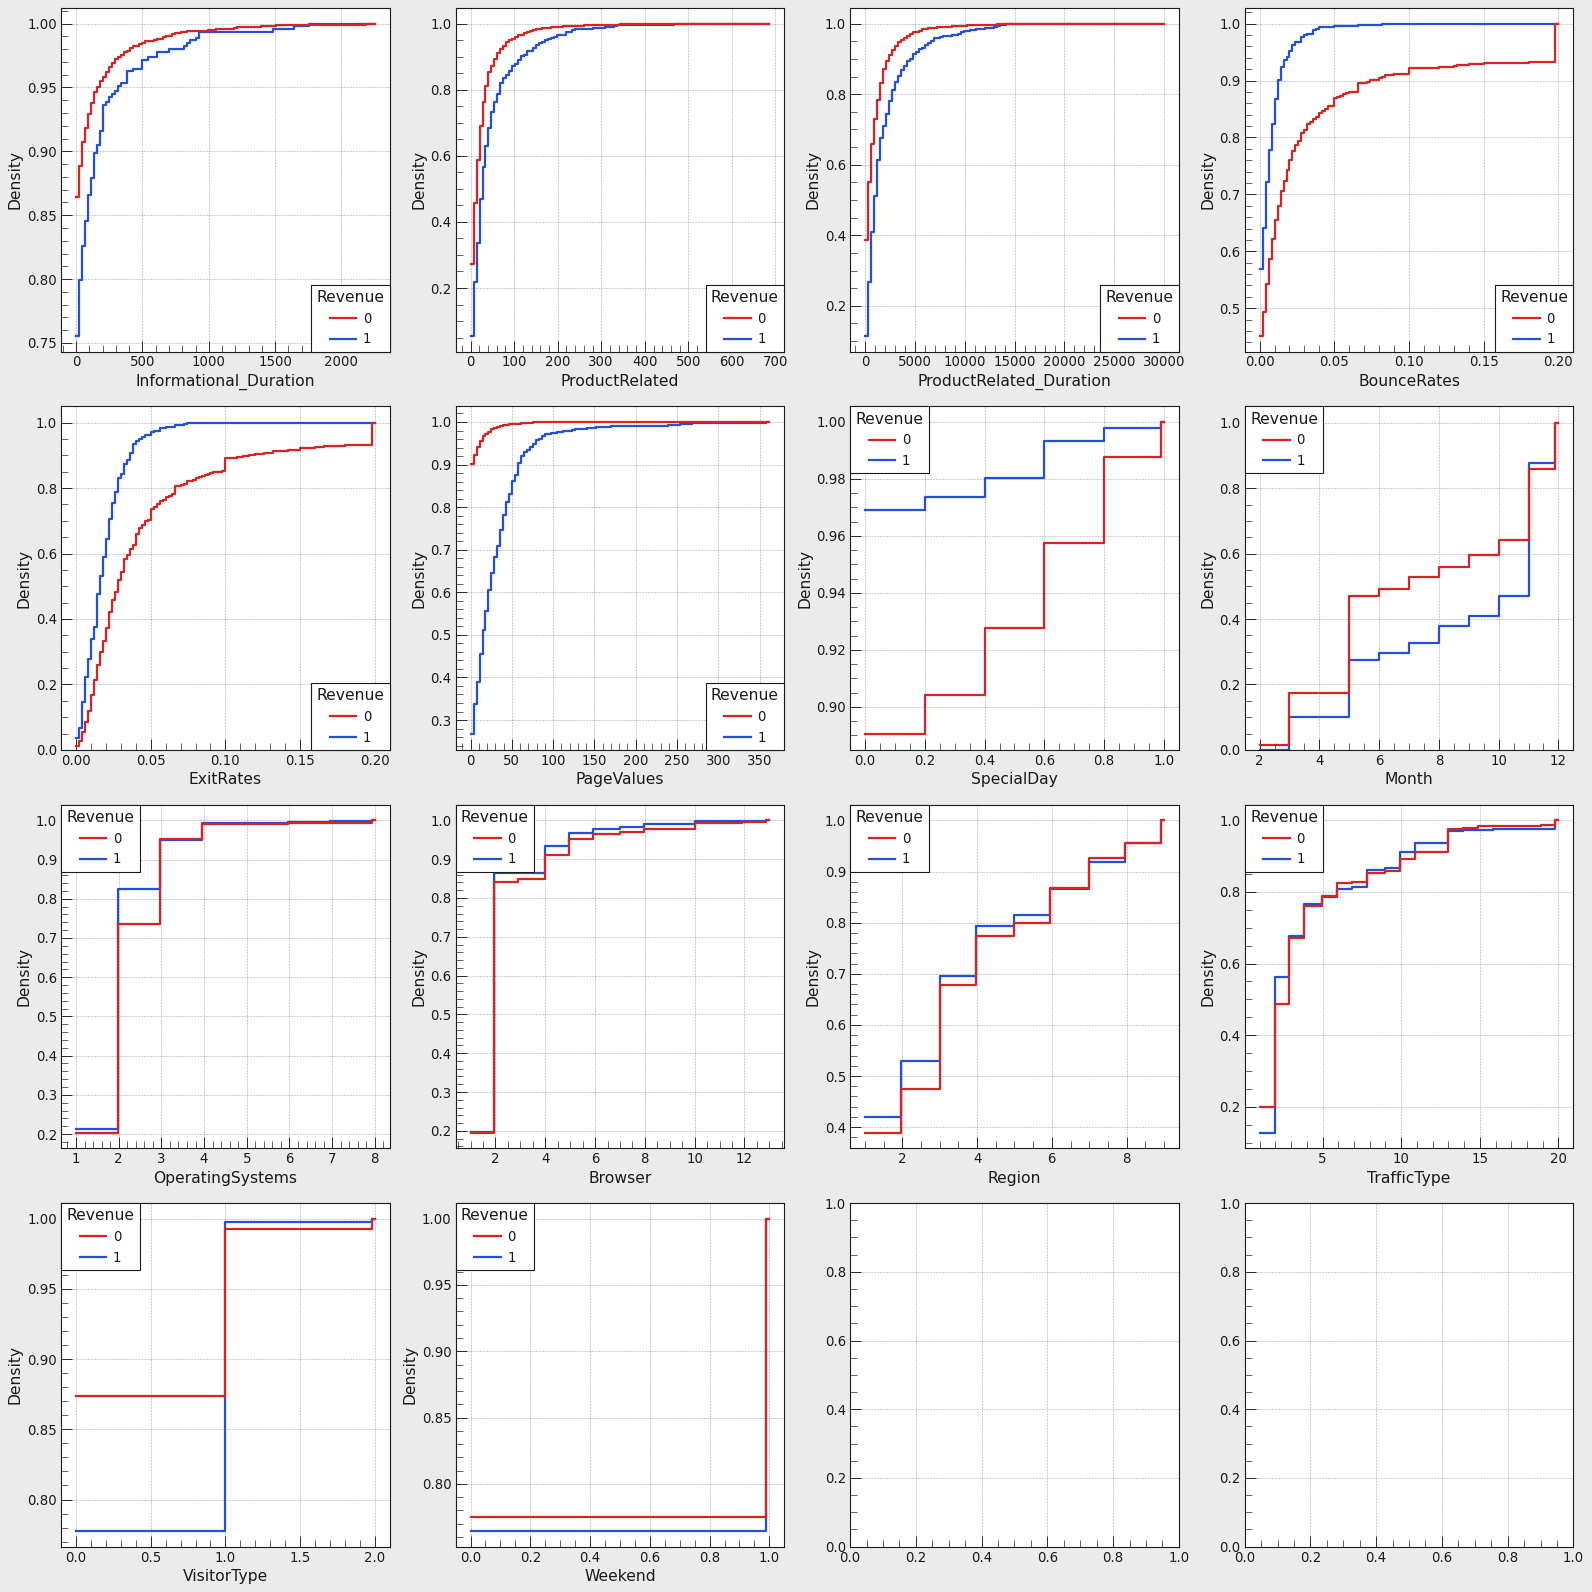

In [ ]:
print(len(train.keys()[1:-1]))

fig, axes = plt.subplots(4,4, figsize = (20,20))
for ax, key in zip(axes.flatten(), (train.keys()[1:-1])):
    sns.histplot(data = train, x = key, hue = "Revenue", ax = ax, element="step", fill = False, stat="density", cumulative=True, common_norm=False, bins = 100)
    # sns.histplot(data = train[train["Revenue"] == 0], x = key, ax = ax, multiple="dodge", stat="density", label = "0", color = "r")
    # sns.histplot(data = train[train["Revenue"] == 1], x = key, ax = ax, multiple="dodge", stat="density", label = "1", color = "g")
    # ax.legend()
    # ax.set_title(key) 
plt.tight_layout()

In [398]:
data_keys = train.keys()[:-1]
classifier_key = train.keys()[-1]
grad_BDT = Gra_classifier(n_estimators=55, max_depth=3)
grad_BDT.fit(train[data_keys].values, train[classifier_key].values)
print(grad_BDT.score(train[data_keys], train[classifier_key]))
print(grad_BDT.score(test[data_keys], test[classifier_key]))
scored = grad_BDT.decision_function(test[data_keys].values)

0.922
0.8956666666666667


,Score,Revenue
0,1.947187,1.0
1,-4.191007,0.0
2,-2.744682,0.0
3,-4.209453,0.0
4,-4.448739,0.0
...,...,...
2995,-4.349743,0.0
2996,-4.387200,0.0
2997,-4.399816,0.0
2998,-3.497862,0.0


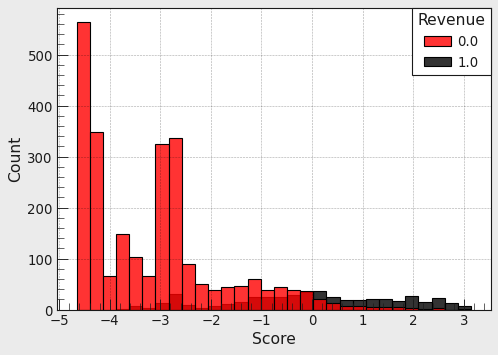

In [399]:
df = pd.DataFrame([scored, test[classifier_key]]).T
df.columns = ["Score", "Revenue"]
display(df)
fig, ax = plt.subplots()
sns.histplot(data= df, x = "Score", hue = "Revenue", bins = 30, palette=["r", "k"], ax = ax, alpha = 0.8)
plt.savefig("BDT.pdf", facecolor = "white")

In [402]:
threshold = -1.8
y_pred = [0.0 if value < threshold else 1 for value in df["Score"]]
print(confusion_matrix(df["Revenue"].values, y_pred, normalize = "true"))

[[0.84761905 0.15238095]
 [0.15416667 0.84583333]]


In [411]:
blind_predict = grad_BDT.predict(blind)
revenue = blind.index.values[blind_predict == 1]
no_revenue = blind.index.values[blind_predict == 0]
np.savetxt("kofoed-djursner.Problem4.RevenueFalse.txt", no_revenue, fmt = "%d")
np.savetxt("kofoed-djursner.Problem4.RevenueTrue.txt", revenue, fmt = "%d")

In [ ]:
n_est_tests = np.linspace(40, 60, 21, dtype=int)
# depth_tests = np.linspace(2, 3, , dtype=int)
# lr_tests = np.linspace(0.02, 0.2, 10)
# mss_tests = np.linspace(5, 100, 20, dtype = int) # min_samples_split
# max_features_test = np.linspace(1, 15, 15,dtype=int)
# print(itertools.product(n_est_tests, depth_tests))
train_score = []
test_score = []
train_score_auc = []
test_score_auc = []

def test_variable(X_train, y_train, X_test, y_test, **kwargs):
    grad_BDT = Ada_classifier(**kwargs)
    grad_BDT.fit(X_train, y_train)
    
    train_score = grad_BDT.score(X_train, y_train)
    test_score = grad_BDT.score(X_test, y_test)
    return train_score, test_score
train_matrix = np.zeros(len(n_est_tests))

test_matrix = np.zeros_like(train_matrix)
# data_matrix = np.zeros_like(train_matrix, dtype=np.object0)
for i, n_est in enumerate(n_est_tests):
    train_score, test_score = test_variable(train[data_keys], train[classifier_key], test[data_keys], test[classifier_key], n_estimators = n_est)
    train_matrix[i] = train_score
    test_matrix[i] = test_score
        # data_matrix[i][j] = (n_est, lr)
# grad_BDT = Gra_classifier()
# grad_BDT.fit(train[data_keys], train[classifier_key])

# train_score.append(grad_BDT.score(train[data_keys], train[classifier_key]))
# test_score.append(grad_BDT.score(test[data_keys], test[classifier_key]))
    
    
# train_pred = grad_BDT.predict(train[data_keys])
# fpr_train, tpr_train, _= roc_curve(train[classifier_key], train_pred)
# train_score_auc.append(auc(fpr_train, tpr_train))

# test_pred = grad_BDT.predict(test[data_keys])
# fpr_test, tpr_test, _= roc_curve(test[classifier_key], test_pred)
# test_score_auc.append(auc(fpr_test, tpr_test))

In [ ]:
minarg = np.argmin(train_matrix - test_matrix)
argmax = np.argmax(test_matrix)
print(train_matrix.flatten()[minarg], test_matrix.flatten()[minarg])
print(data_matrix.flatten()[minarg])

0.901 0.8886666666666667
(90, 2, 0.02)


In [ ]:
plt.figure(figsize = (15,10))
# for line, depth in zip(train_matrix.T, max_features_test):
plt.plot(n_est_tests, train_matrix)
plt.legend()
plt.show()
plt.figure(figsize = (15,10))
# for line, depth in zip(test_matrix.T, max_features_test):
plt.plot(n_est_tests, test_matrix)
plt.legend()
plt.show()
plt.figure(figsize = (15,10))
# for line, depth in zip(test_matrix.T, max_features_test):
plt.plot(n_est_tests, train_matrix - test_matrix)
plt.legend()
plt.show()

In [ ]:
plt.plot(n_est_tests, train_score, label = "train")
plt.plot(n_est_tests, test_score, label = "test")
# plt.plot(n_est_tests, np.array(train_score)- np.array(test_score), label = "difference")
# plt.ylim(0, 0.2)
plt.legend()
plt.show()
plt.plot(n_est_tests, train_score_auc, label = "train")
plt.plot(n_est_tests, test_score_auc, label = "test")
plt.plot(n_est_tests, np.array(train_score_auc)- np.array(test_score_auc), label = "difference")
plt.legend()
plt.show()

In [ ]:

test_pred = grad_BDT.predict(test[data_keys])
false_positive_rate, true_positive_rate, thresholds = roc_curve(test[classifier_key], test_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

[0.         0.03809524 1.        ] [0.   0.55 1.  ]
0.755952380952381
